In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

# pyomo
import importlib
import neural_net_pyomo

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [87]:
data = pd.read_csv('df_train.csv')

data = data[data.settlement_date >= '2010-01-01']
data = data[data.settlement_date < '2011-01-01']
data.reset_index(drop=True, inplace=True)

#display(data.info())
#display(data.isna().sum())

data_subsample = data[:400]
data_subsample.shape

display(data.head())

,settlement_date,temperature,conditions,precip,cloudcover,humidity,windspeed,nd,pump_storage_pumping,is_holiday
0,2010-01-01 00:00:00,2.5,Partially cloudy,0.0,43.6,75.52,16.2,36566.5,264.5,1.0
1,2010-01-01 01:00:00,0.6,Partially cloudy,0.0,36.1,86.19,14.0,35852.5,289.5,1.0
2,2010-01-01 02:00:00,0.8,Partially cloudy,0.0,48.8,85.14,16.7,34189.5,461.0,1.0
3,2010-01-01 03:00:00,0.7,Partially cloudy,0.0,68.1,83.74,13.9,32453.0,1334.0,1.0
4,2010-01-01 04:00:00,0.4,Partially cloudy,0.0,34.5,83.66,12.2,30450.5,1387.5,1.0


In [88]:
data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour

# select the main columns for the intial testing
data_subsample = data_subsample[['temperature', 'hour', 'nd']]
data_subsample.head()

/var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_20732/3108936087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subsample.loc[:,'hour'] = pd.to_datetime(data_subsample['settlement_date']).dt.hour


In [39]:
t = jnp.linspace(0., 1., data_subsample.shape[0])

def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

In [89]:
# interpolate the whole dataset
cs_temp = CubicSpline(t, data_subsample['temperature'])
cs_hour = CubicSpline(t, data_subsample['hour'])
cs_nd = CubicSpline(t, data_subsample['nd'])

In [151]:
split = 100

t_train = t[:split]
t_test = t[split:]

In [148]:
x_train_cheb = generate_chebyshev_nodes(t_train.shape[0], 0, t_train.max())

y_train_temp = cs_temp(x_train_cheb)
y_train_hour = cs_hour(x_train_cheb)
y_train_nd = cs_nd(x_train_cheb)

In [149]:
X_train = np.vstack([y_train_temp, y_train_hour]).T
print(X_train.shape)
X_train = pd.DataFrame(X_train, columns=['temperature', 'hour'])
y_train = pd.DataFrame(y_train_nd)

(100, 2)


In [150]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns
#X_test_scaled = pd.DataFrame(X_test_scaled)
#X_test_scaled.columns = X_test.columns

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
#y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

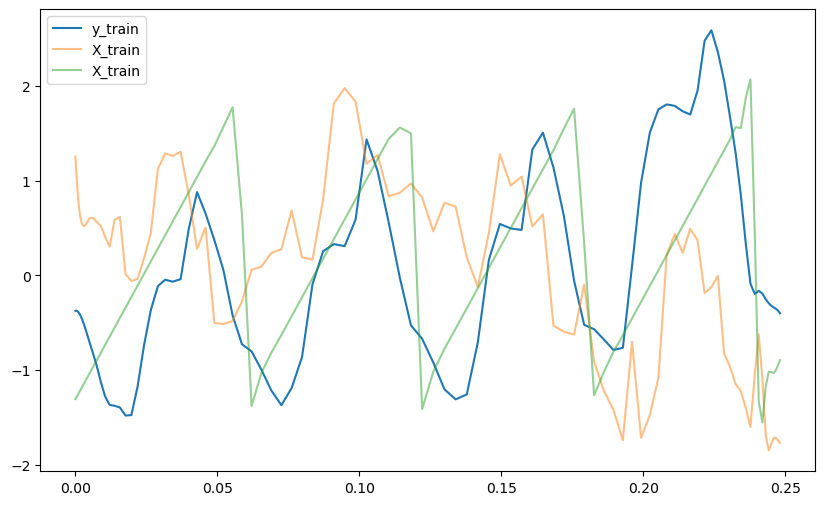

In [152]:
plt.figure(figsize=(10, 6))
# plt.plot(t, data_subsample['temperature'], color='red', label='Original Data')
plt.plot(x_train_cheb, y_train_scaled, label='y_train')
plt.plot(x_train_cheb, X_train_scaled, label='X_train', alpha = 0.5)

#plt.plot(x_train_cheb[split:], y_test_scaled, label='y_train', ls = '--')
#plt.plot(x_train_cheb[split:], X_test_scaled, label='X_train', alpha = 0.5)

plt.legend()
plt.show()

In [154]:
weights = compute_weights(x_train_cheb)
D = np.array(lagrange_derivative(x_train_cheb, weights))

In [156]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  
    
    embeddings = []  
    
    for i in range(n - m * tau):
        if x.ndim == 2:
             embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  
        elif x.ndim == 1:
            embedding = jnp.array([x[i + j * tau] for j in range(m)])     
        else:
            raise ValueError("Input array x must be either 1D or 2D.")
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

tau = 1
m = 3
embeddings = create_delayed_embeddings(y_train_scaled, tau, m)
print(embeddings.shape)

(97, 3)


In [171]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [172]:
offset = m*tau
layer_widths = [1 + 2, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-2, "print_level": 5, 
          "hessian_approximation": 'limited-memory', 
          # 'mu_strategy': 'adaptive', 
          "dual_inf_tol": 1e-2, 
          "constr_viol_tol": 1e-2, 
          "compl_inf_tol": 1e-2,
          "check_derivatives_for_naninf": 'yes',
          "max_iter": 3000}

start_timer_build = time.time()
ode_model = NeuralODEPyomo(np.array(y_train_scaled[offset : split]), # y
                           np.array(x_train_cheb[offset : split]), # t
                           np.array(D[offset : split, offset : split]),
                           
                           layer_widths, act_func = "tanh", 
                           y_init = np.array(y_train_scaled[offset : split]), penalty_lambda = 0.0001, 
                           penalty_lambda_input = 0.001,
                           
                           extra_input = np.array(X_train_scaled[offset : split]), # X
                           w_init_method = 'xavier', params = params
                           )

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: halt_on_ampl_error=yes
tol=0.01
print_level=5
hessian_approximation=limited-memory
dual_inf_tol=0.01
constr_viol_tol=0.01
compl_inf_tol=0.01
check_derivatives_for_naninf=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    19008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      198
                     variables with only lower bounds:        0
              

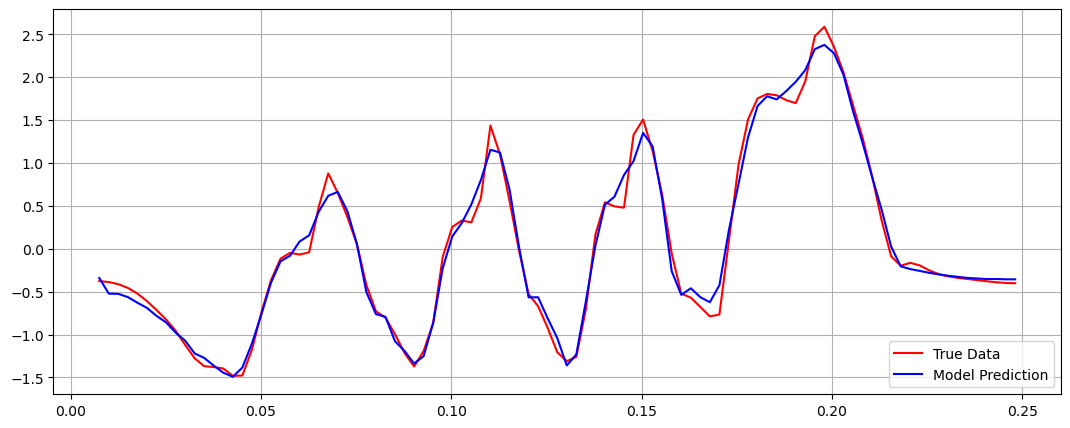

In [173]:
plt.figure(figsize=(13, 5))
plt.plot(t_train[offset : split], y_train_scaled[offset : split], 'r', label='True Data')
plt.plot(t_train[offset : split], u_model, 'b', label='Model Prediction')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [ ]:
# def neural_ode(self, y0, t, extra_args = None):

In [ ]:
y_init = y_train_scaled[offset : split][0]
t = x_train_cheb[offset : split]
extra_args = X_train_scaled[offset : split]

ode_model.neural_ode(y_train_scaled[offset : split])

In [159]:
from scipy.integrate import solve_ivp

In [164]:
t_new = x_train_cheb[offset : split]
t_new.shape
X_train_scaled[offset : split].shape

(97, 2)

In [167]:
X_train_scaled[offset : split]

,temperature,hour
3,0.959727,-1.277286
4,0.791652,-1.253379
5,0.642722,-1.222682
6,0.544745,-1.185226
7,0.516285,-1.141050
...,...,...
95,-1.732811,-0.970897
96,-1.751552,-0.938147
97,-1.763682,-0.914371
98,-1.769392,-0.900562


In [ ]:
def neural_ode(self, params, y0, t, state, extra_args=None): 
    results = []    
       
    def func(y, t, args):
        input = jnp.atleast_1d(y)
        
        if not self.time_invariant:
            input = jnp.append(input, t)
            
        if args is not None:
            extra_inputs, t_all = args
            
            if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
                # after confirming that extra inputs is an array
                # there are 2 further options to consider:
                # multiple datapoints and multiple features
                
                if extra_inputs.ndim == 2:
                    # we have multiple datapoints
                    index = jnp.argmin(jnp.abs(t_all - t))
                    for extra_input in extra_inputs[index]:
                            input = jnp.append(input, extra_input)
                            
                elif extra_inputs.ndim == 1:
                    # we have a single datapoint so no need to slice the index
                    for extra_input in extra_inputs:
                            input = jnp.append(input, extra_input)
                    
            else: # if a single value, simply append it
                input = jnp.append(input, extra_inputs)
        
        result = state.apply_fn({'params': params}, input) 
             
        return result
        
    return odeint(func, y0, t, extra_args)

In [166]:
def func(y, t, args):
    input = jnp.atleast_1d(y)
    
    if not self.time_invariant:
        input = jnp.append(input, t)
        
    if args is not None:
        extra_inputs, t_all = args
        
        if isinstance(extra_inputs, (np.ndarray, jnp.ndarray)):
            # after confirming that extra inputs is an array
            # there are 2 further options to consider:
            # multiple datapoints and multiple features
            
            if extra_inputs.ndim == 2:
                # we have multiple datapoints
                index = jnp.argmin(jnp.abs(t_all - t))
                for extra_input in extra_inputs[index]:
                        input = jnp.append(input, extra_input)
                        
            elif extra_inputs.ndim == 1:
                # we have a single datapoint so no need to slice the index
                for extra_input in extra_inputs:
                        input = jnp.append(input, extra_input)
                
        else: # if a single value, simply append it
            input = jnp.append(input, extra_inputs)
    
    result = state.apply_fn({'params': params}, input) 
            
    return result
    
def system_dynamics(t, y, embeddings, t_new):
    # -1 to account for the zero indexing
    current_index = np.searchsorted(t_new, t, side='right') - 1
    
    input = np.array([y[0]])
    
    # for each embedding:
    for i in range(m):
        input = np.append(input, embeddings[current_index][i])
        
    # input = np.array([y[0]])
    du_dt = ode_model.predict(input) 
    return du_dt

initial_conditions = np.array(y_train_scaled[offset])
t_span = (t_new[0], t_new[-1])
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(X_train_scaled[offset : split], t_new))

y_pred_train = sol.y
t_points = sol.t

ode_solution = np.squeeze(y_pred_train.T)

KeyError: 0

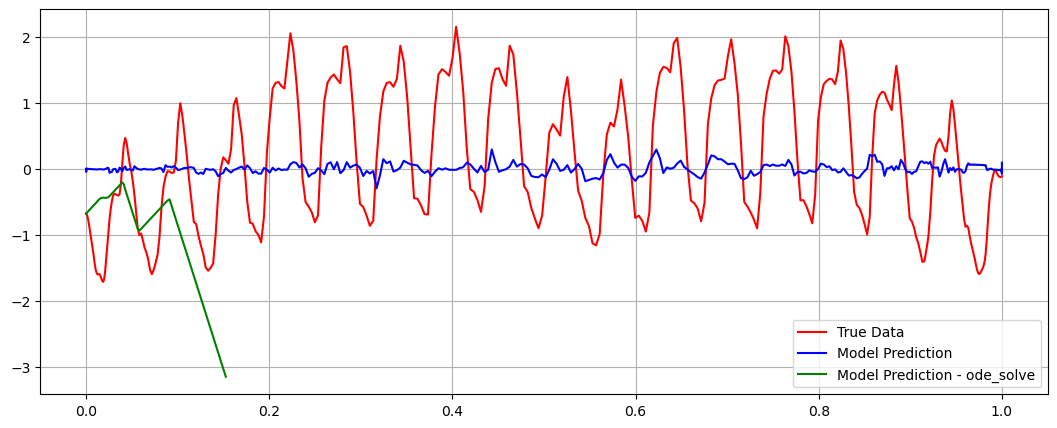

In [126]:
plt.figure(figsize=(13, 5))
plt.plot(t_train[offset : split], y_train_scaled[offset : split], 'r', label='True Data')
plt.plot(t_train[offset : split], u_model, 'b', label='Model Prediction')
plt.plot(t_train[offset : split][:100], ode_solution[:100], 'g', label='Model Prediction - ode_solve')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()